In [2]:
import cftime
import numpy as np
import xarray as xr
import climpred
import proplot as plot
import glob
from tqdm import tqdm
import dask.array as da
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FixedLocator
import warnings
warnings.filterwarnings("ignore")

from dask.distributed import Client
import dask.config
dask.config.set({"array.slicing.split_large_chunks": False})

In [3]:
client = Client("tcp://10.12.205.30:33116")

OSError: Timed out trying to connect to tcp://10.12.205.30:33116 after 10 s

In [42]:
verifdata = "CPC" #can be ERA5 or CPC
#domain = "global"
domain = "North America"
metric = "rmse" #can be rps, crps, crpss, rmse, acc
if metric == "acc" or metric=="rmse":
    comp="e2o"
    dim="init"
else:
    comp="m2o"
    dim=["init","member"]

In [43]:
hinda2 = xr.open_zarr("/glade/campaign/cesm/development/cross-wg/S2S/jaye/CESM2.S2S.tas_2m.anoms.wklead.zarr/", consolidated=True)
hinda1 = xr.open_zarr("/glade/campaign/cesm/development/cross-wg/S2S/jaye/CESM1.S2S.tas_2m.anoms.wklead.zarr/", consolidated=True)
hindaw = xr.open_zarr("/glade/campaign/cesm/development/cross-wg/S2S/jaye/WACCM.S2S.tas_2m.anoms.wklead.zarr/", consolidated=True)
verif = xr.open_zarr("/glade/campaign/cesm/development/cross-wg/S2S/jaye/"+verifdata+".tas.zarr/", consolidated=True)
land = xr.open_dataset("/glade/work/jaye/landsea.nc")

In [44]:
# converting to a proleptic gregorian calendar since the observations
# have leap years. you could also just drop the leap year days from
# the obs.
hinda2["init"] = [cftime.DatetimeProlepticGregorian(d.year, d.month, d.day) for d in hinda2["init"].values]
hinda1["init"] = [cftime.DatetimeProlepticGregorian(d.year, d.month, d.day) for d in hinda1["init"].values]
hindaw["init"] = [cftime.DatetimeProlepticGregorian(d.year, d.month, d.day) for d in hindaw["init"].values]

# designate the lead time step unit.
hinda2["lead"].attrs["units"] = "days"
hinda1["lead"].attrs["units"] = "days"
hindaw["lead"].attrs["units"] = "days"

In [45]:
# Convert our verification product to the same calendar type.
# Climpred just needs to see the same datetime object styles for
# alignment. You could use numpy datestrings or pandas on both,
# cftime.noleap or gregorian, etc.
def convert_to_cftime(x):
    x = str(x)
    y, m, d = x.split("-")
    y = int(y)
    m = int(m)
    d = int(d.split("T")[0])
    return cftime.DatetimeProlepticGregorian(y, m, d)


verif["time"] = [convert_to_cftime(t) for t in verif.time.values]

In [46]:
hindaw = hindaw.sel(init=slice("1999-01-01", "2015-12-31"))
hinda1 = hinda1.sel(init=slice("1999-01-01", "2015-12-31"))
hinda2 = hinda2.sel(init=slice("1999-01-01", "2015-12-31"))
verif = verif.sel(time=slice("1999-01-01","2015-12-31"))

In [47]:
#Weird stuff in new zealand happening. This is easiest way to fix that i have found.
if verifdata=="CPC":
    verif = verif.where(-100<verif.TAS)
    verif = verif.where(100>verif.TAS)

In [48]:
verif = verif.isel(lat=slice(0,-1))
hinda2 = hinda2.isel(lat=slice(0,-1))
hinda1 = hinda1.isel(lat=slice(0,-1))
hindaw = hindaw.isel(lat=slice(0,-1))
verif.coords['mask'] = (("lat","lon"),land.LSMASK)
hinda2.coords['mask'] = (("lat","lon"),land.LSMASK)
hinda1.coords['mask'] = (("lat","lon"),land.LSMASK)
hindaw.coords['mask'] = (("lat","lon"),land.LSMASK)

In [49]:
if domain == "North America":
    hinda2 = hinda2.sel(lat=slice(15.0, 75.0))
    hinda2 = hinda2.sel(lon=slice(190.0, 305.0))
    hinda1 = hinda1.sel(lat=slice(15.0, 75.0))
    hinda1 = hinda1.sel(lon=slice(190.0, 305.0))
    hindaw = hindaw.sel(lat=slice(15.0, 75.0))
    hindaw = hindaw.sel(lon=slice(190.0, 305.0))
    verif = verif.sel(lat=slice(15.0, 75.0))
    verif = verif.sel(lon=slice(190.0, 305.0))

In [50]:
hinda2 = hinda2.where(hinda2.mask==1)
hinda1 = hinda1.where(hinda1.mask==1)
hindaw = hindaw.where(hindaw.mask==1)
verif = verif.where(verif.mask==1)

In [51]:
verif = verif.chunk({"time": -1, "lat": "auto", "lon": "auto"}).persist()
hindaw = hindaw.chunk({"member": -1, "init": -1, "lead": "auto", "lat": 36, "lon": 72}).persist()
hinda1 = hinda1.chunk({"member": -1, "init": -1, "lead": "auto", "lat": 36, "lon": 72}).persist()
hinda2 = hinda2.chunk({"member": -1, "init": -1, "lead": "auto", "lat": 36, "lon": 72}).persist()

In [52]:
hindaw_djf = hindaw.sel(init=hindaw.init.dt.season=="DJF")
hinda1_djf = hinda1.sel(init=hinda1.init.dt.season=="DJF")
hinda1_jja = hinda1.sel(init=hinda1.init.dt.season=="JJA")
hinda2_djf = hinda2.sel(init=hinda2.init.dt.season=="DJF")
hinda2_jja = hinda2.sel(init=hinda2.init.dt.season=="JJA")
verif_djf = verif.sel(time=verif.time.dt.season=="DJF")
verif_jja = verif.sel(time=verif.time.dt.season=="JJA")

In [53]:
hinda1_5_djf = hinda1_djf.sel(member = slice(0,4))
hinda2_5_djf = hinda2_djf.sel(member = slice(0,4))
hinda1_5_jja = hinda1_jja.sel(member = slice(0,4))
hinda2_5_jja = hinda2_jja.sel(member = slice(0,4))

In [1]:
#Calculate ensemble spread
ensprw_djf = hindaw_djf.TAS.std("member").weighted(np.cos(np.deg2rad(hindaw_djf.lat))).mean(("lat","lon")).mean("init")
enspr1_djf = hinda1_djf.TAS.std("member").weighted(np.cos(np.deg2rad(hinda1_djf.lat))).mean(("lat","lon")).mean("init")
enspr2_djf = hinda2_djf.TAS.std("member").weighted(np.cos(np.deg2rad(hinda2_djf.lat))).mean(("lat","lon")).mean("init")
enspr1_5_djf = hinda1_5_djf.TAS.std("member").weighted(np.cos(np.deg2rad(hinda1_5_djf.lat))).mean(("lat","lon")).mean("init")
enspr2_5_djf = hinda2_5_djf.TAS.std("member").weighted(np.cos(np.deg2rad(hinda2_5_djf.lat))).mean(("lat","lon")).mean("init")
enspr1_jja = hinda1_jja.TAS.std("member").weighted(np.cos(np.deg2rad(hinda1_jja.lat))).mean(("lat","lon")).mean("init")
enspr2_jja = hinda2_jja.TAS.std("member").weighted(np.cos(np.deg2rad(hinda2_jja.lat))).mean(("lat","lon")).mean("init")
enspr1_5_jja = hinda1_5_jja.TAS.std("member").weighted(np.cos(np.deg2rad(hinda1_5_jja.lat))).mean(("lat","lon")).mean("init")
enspr2_5_jja = hinda2_5_jja.TAS.std("member").weighted(np.cos(np.deg2rad(hinda2_5_jja.lat))).mean(("lat","lon")).mean("init")

NameError: name 'hindaw_djf' is not defined

In [ ]:
hindcastw_djf = climpred.HindcastEnsemble(hindaw_djf).add_observations(verif_djf)
hindcast1_djf = climpred.HindcastEnsemble(hinda1_djf).add_observations(verif_djf)
hindcast2_djf = climpred.HindcastEnsemble(hinda2_djf).add_observations(verif_djf)
hindcast1_5_djf = climpred.HindcastEnsemble(hinda1_5_djf).add_observations(verif_djf)
hindcast2_5_djf = climpred.HindcastEnsemble(hinda2_5_djf).add_observations(verif_djf)
hindcast1_jja = climpred.HindcastEnsemble(hinda1_jja).add_observations(verif_jja)
hindcast2_jja = climpred.HindcastEnsemble(hinda2_jja).add_observations(verif_jja)
hindcast1_5_jja = climpred.HindcastEnsemble(hinda1_5_jja).add_observations(verif_jja)
hindcast2_5_jja = climpred.HindcastEnsemble(hinda2_5_jja).add_observations(verif_jja)

In [ ]:
if metric=="rps":
    bins = np.array([0.0,0.333,0.666])
    #bins = np.array([-10,-3,3])
    rpsw_djf = hindcastw_djf.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize', category_edges=bins)
    rps1_djf = hindcast1_djf.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize', category_edges=bins)
    rps2_djf = hindcast2_djf.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize', category_edges=bins)
    rps1_5_djf = hindcast1_5_djf.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize', category_edges=bins)
    rps2_5_djf = hindcast2_5_djf.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize', category_edges=bins)
    rps1_jja = hindcast1_jja.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize', category_edges=bins)
    rps2_jja = hindcast2_jja.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize', category_edges=bins)
    rps1_5_jja = hindcast1_5_jja.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize', category_edges=bins)
    rps2_5_jja = hindcast2_5_jja.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize', category_edges=bins)
else:
    rpsw_djf = hindcastw_djf.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize')
    rps1_djf = hindcast1_djf.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize')
    rps2_djf = hindcast2_djf.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize')
    rps1_5_djf = hindcast1_5_djf.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize')
    rps2_5_djf = hindcast2_5_djf.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize')
    rps1_jja = hindcast1_jja.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize')
    rps2_jja = hindcast2_jja.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize')
    rps1_5_jja = hindcast1_5_jja.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize')
    rps2_5_jja = hindcast2_5_jja.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize')

In [57]:
#crpsw_persistence = climpred.reference.compute_persistence(hindaw,verif,metric='mae',alignment='maximize',add_attrs=True,dim='init')
#crpss1 = 1-crpsw./crpsw_persistence

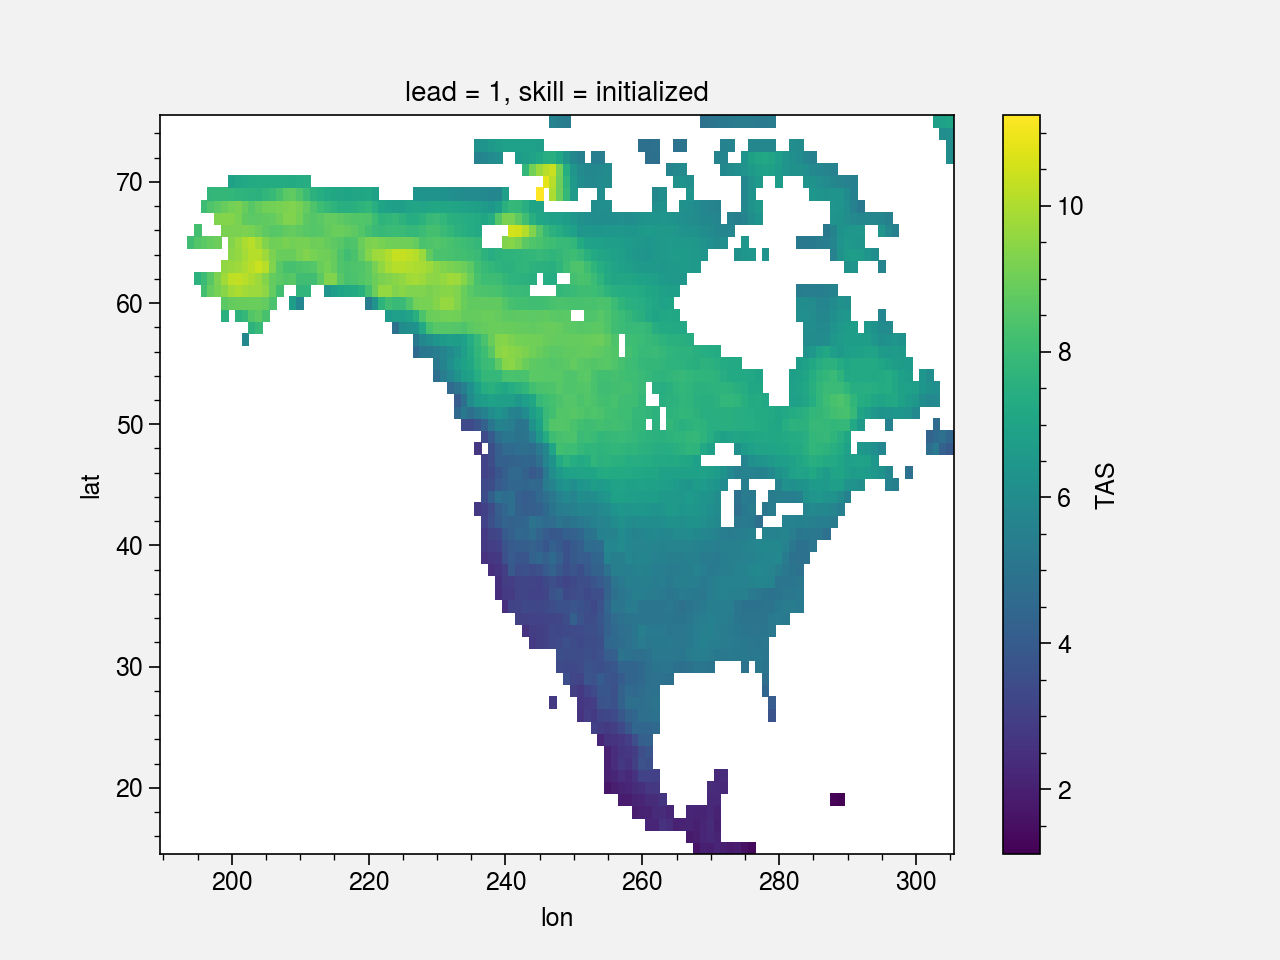

In [73]:
#rps2_djf.TAS.sel(lead=slice(1,2)).mean("lead").plot()
rps2_djf.TAS.sel(lead=1).plot()

In [59]:
if metric=="rps":
    rpsw_djf = rpsw_djf.where(hindaw.mask==1)
    rps1_djf = rps1_djf.where(hindaw.mask==1)
    rps2_djf = rps2_djf.where(hindaw.mask==1)
    rps1_5_djf = rps1_5_djf.where(hindaw.mask==1)
    rps2_5_djf = rps2_5_djf.where(hindaw.mask==1)
    rps1_jja = rps1_jja.where(hindaw.mask==1)
    rps2_jja = rps2_jja.where(hindaw.mask==1)
    rps1_5_jja = rps1_5_jja.where(hindaw.mask==1)
    rps2_5_jja = rps2_5_jja.where(hindaw.mask==1)
    rps1_jja.TAS.sel(lead=slice(2,3)).mean("lead").plot()

In [60]:
rpsw_djf_aw = rpsw_djf.weighted(np.cos(np.deg2rad(rpsw_djf.lat))).mean(("lat","lon")).persist()
rps1_djf_aw = rps1_djf.weighted(np.cos(np.deg2rad(rps1_djf.lat))).mean(("lat","lon")).persist()
rps2_djf_aw = rps2_djf.weighted(np.cos(np.deg2rad(rps2_djf.lat))).mean(("lat","lon")).persist()
rps1_5_djf_aw = rps1_5_djf.weighted(np.cos(np.deg2rad(rps1_5_djf.lat))).mean(("lat","lon")).persist()
rps2_5_djf_aw = rps2_5_djf.weighted(np.cos(np.deg2rad(rps2_5_djf.lat))).mean(("lat","lon")).persist()
rps1_jja_aw = rps1_jja.weighted(np.cos(np.deg2rad(rps1_djf.lat))).mean(("lat","lon")).persist()
rps2_jja_aw = rps2_jja.weighted(np.cos(np.deg2rad(rps2_djf.lat))).mean(("lat","lon")).persist()
rps1_5_jja_aw = rps1_5_jja.weighted(np.cos(np.deg2rad(rps1_5_djf.lat))).mean(("lat","lon")).persist()
rps2_5_jja_aw = rps2_5_jja.weighted(np.cos(np.deg2rad(rps2_5_djf.lat))).mean(("lat","lon")).persist()

In [61]:
#Ensemble spread
#hinda2_djf.TAS.std("member").mean(("lat","lon")).mean("init").plot()

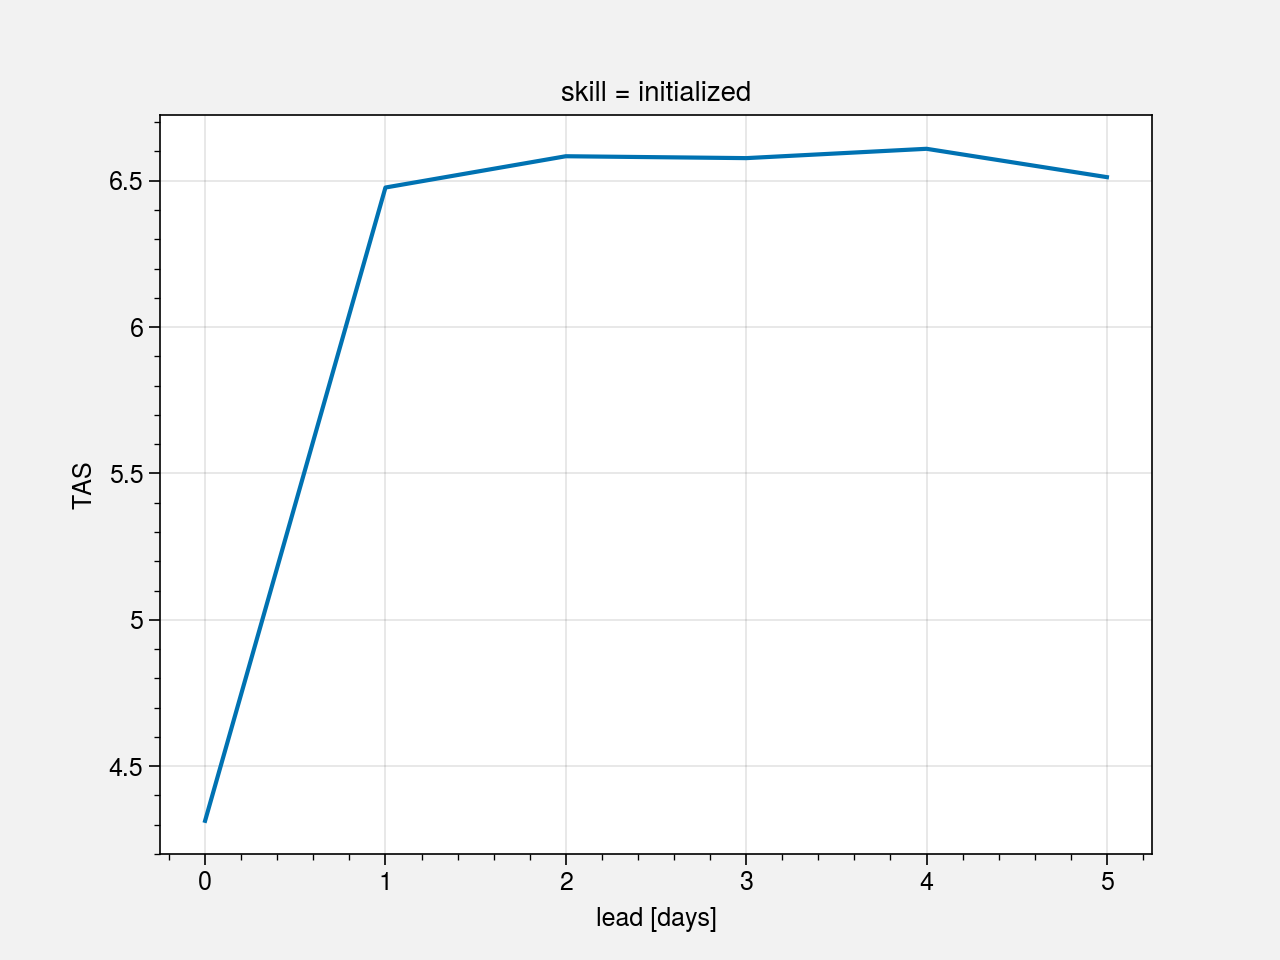

In [74]:
#Ensemble mean if metric = 'RMSE"'
rps2_djf.TAS.mean(("lat", "lon")).plot()

In [63]:
barWidth = 0.15
barsw = [rpsw_djf_aw.TAS.sel(lead=slice(0,1)).mean("lead").compute(),
         rpsw_djf_aw.TAS.sel(lead=slice(2,3)).mean("lead").compute(),
         rpsw_djf_aw.TAS.sel(lead=slice(4,5)).mean("lead").compute()]
rw = np.arange(len(barsw))
bars2_5 = [rps2_5_djf_aw.TAS.sel(lead=slice(0,1)).mean("lead").compute(),
           rps2_5_djf_aw.TAS.sel(lead=slice(2,3)).mean("lead").compute(),
           rps2_5_djf_aw.TAS.sel(lead=slice(4,5)).mean("lead").compute()]
r2_5 = [x + barWidth + 0.025 for x in rw]
bars2 = [rps2_djf_aw.TAS.sel(lead=slice(0,1)).mean("lead").compute(),
         rps2_djf_aw.TAS.sel(lead=slice(2,3)).mean("lead").compute(),
         rps2_djf_aw.TAS.sel(lead=slice(4,5)).mean("lead").compute()]
r2 = [x + barWidth + 0.025 for x in r2_5]
bars1_5 = [rps1_5_djf_aw.TAS.sel(lead=slice(0,1)).mean("lead").compute(),
           rps1_5_djf_aw.TAS.sel(lead=slice(2,3)).mean("lead").compute(),
           rps1_5_djf_aw.TAS.sel(lead=slice(4,5)).mean("lead").compute()]
r1_5 = [x + barWidth + 0.025 for x in r2]
bars1 = [rps1_djf_aw.TAS.sel(lead=slice(0,1)).mean("lead").compute(),
         rps1_djf_aw.TAS.sel(lead=slice(2,3)).mean("lead").compute(),
         rps1_djf_aw.TAS.sel(lead=slice(4,5)).mean("lead").compute()]
r1 = [x + barWidth + 0.025 for x in r1_5]

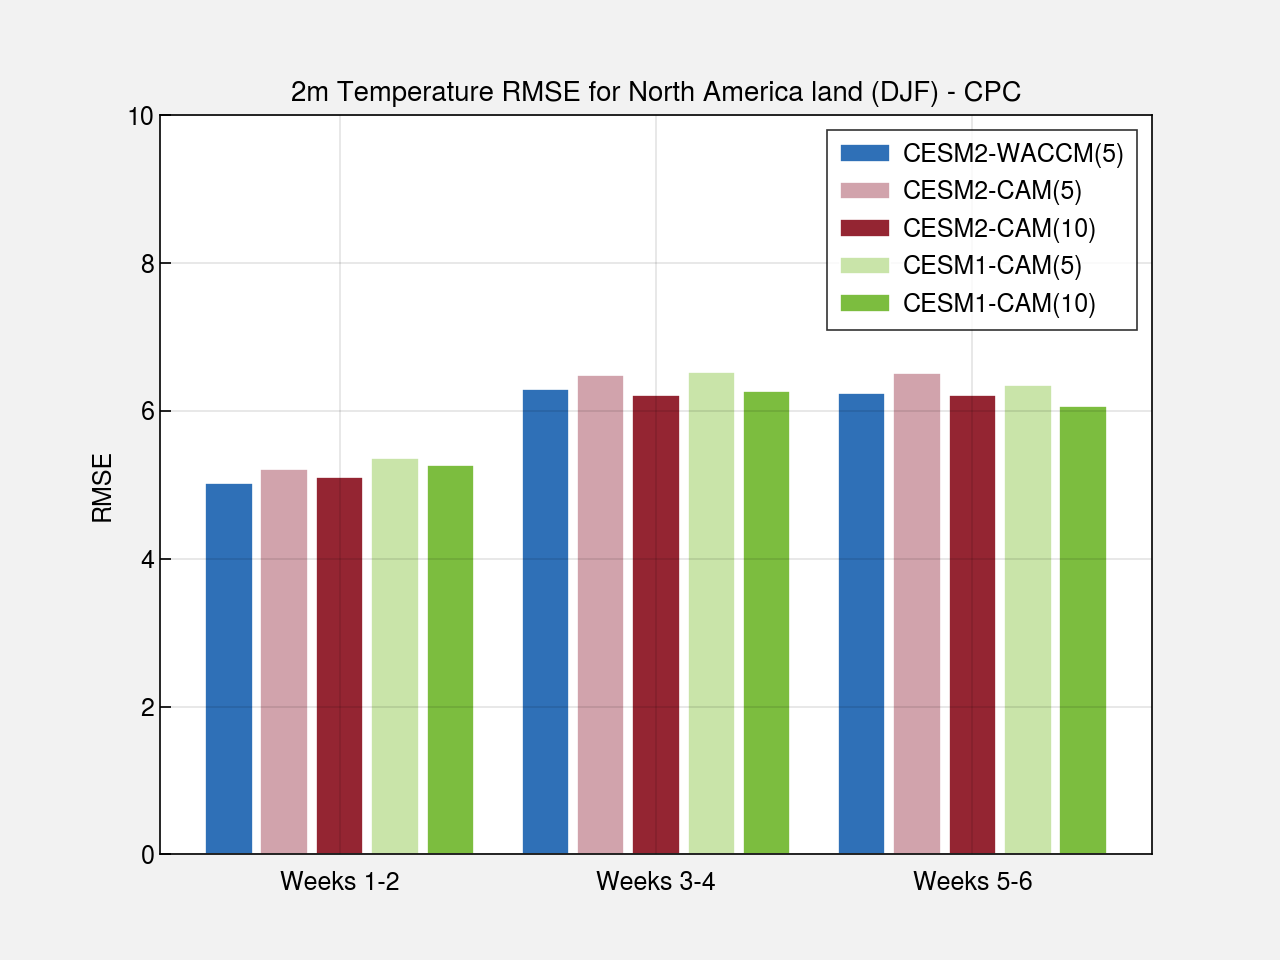

In [64]:
plt.bar(rw, barsw, width = barWidth, color = "#2f70b7", edgecolor="white", label="CESM2-WACCM(5)")
plt.bar(r2_5, bars2_5, width = barWidth, color = "#d1a3ac", edgecolor="white", label="CESM2-CAM(5)")
plt.bar(r2, bars2, width = barWidth, color = "#942532", edgecolor="white", label="CESM2-CAM(10)")
plt.bar(r1_5, bars1_5, width = barWidth, color = "#c9e4a9", edgecolor="white", label="CESM1-CAM(5)")
plt.bar(r1, bars1, width = barWidth, color = "#7cbd3f", edgecolor="white", label="CESM1-CAM(10)")
plt.xticks([r + barWidth + 0.2 for r in range(len(bars1))], ["Weeks 1-2", "Weeks 3-4", "Weeks 5-6"])
plt.tick_params(axis = "y", direction = "in", which = "both")
plt.tick_params(axis = "y", which = "minor", left = False)
plt.tick_params(axis = "x", which = "both", bottom = False, top = False)
if metric=="acc":
    y_locator = FixedLocator([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]) #for rps and acc
    plt.gca().yaxis.set_major_locator(y_locator) #for rps and acc
    plt.ylim(0,1.0) #for rps and acc
elif metric=="rps":
    plt.ylim(0,1.5)
elif metric=="crpss":
    plt.ylim(-0.3,0.1) #for crpss
elif metric=="crps":
    plt.ylim(0,6.0) #for crps
elif metric=="rmse":
    plt.ylim(0,10.0) #for rmse
plt.ylabel(metric.upper())
plt.title("2m Temperature "+metric.upper()+" for "+domain+" land (DJF) - "+verifdata)
plt.legend(borderaxespad=0.6,edgecolor="black")
if domain == "North America":
    plt.savefig(metric+"_NAland_DJF_"+verifdata+".jpg",dpi=300,bbox_inches="tight")
elif domain == "global":
    plt.savefig(metric+"_globalland_DJF_"+verifdata+".jpg",dpi=300,bbox_inches="tight")

In [65]:
barWidth = 0.175
bars2_5 = [rps2_5_jja_aw.TAS.sel(lead=slice(0,1)).mean("lead").persist(),
           rps2_5_jja_aw.TAS.sel(lead=slice(2,3)).mean("lead").persist(),
           rps2_5_jja_aw.TAS.sel(lead=slice(4,5)).mean("lead").persist()]
r2_5 = np.arange(len(bars2_5))
bars2 = [rps2_jja_aw.TAS.sel(lead=slice(0,1)).mean("lead").persist(),
         rps2_jja_aw.TAS.sel(lead=slice(2,3)).mean("lead").persist(),
         rps2_jja_aw.TAS.sel(lead=slice(4,5)).mean("lead").persist()]
r2 = [x + barWidth + 0.025 for x in r2_5]
bars1_5 = [rps1_5_jja_aw.TAS.sel(lead=slice(0,1)).mean("lead").persist(),
           rps1_5_jja_aw.TAS.sel(lead=slice(2,3)).mean("lead").persist(),
           rps1_5_jja_aw.TAS.sel(lead=slice(4,5)).mean("lead").persist()]
r1_5 = [x + barWidth + 0.025 for x in r2]
bars1 = [rps1_jja_aw.TAS.sel(lead=slice(0,1)).mean("lead").persist(),
         rps1_jja_aw.TAS.sel(lead=slice(2,3)).mean("lead").persist(),
         rps1_jja_aw.TAS.sel(lead=slice(4,5)).mean("lead").persist()]
r1 = [x + barWidth + 0.025 for x in r1_5]

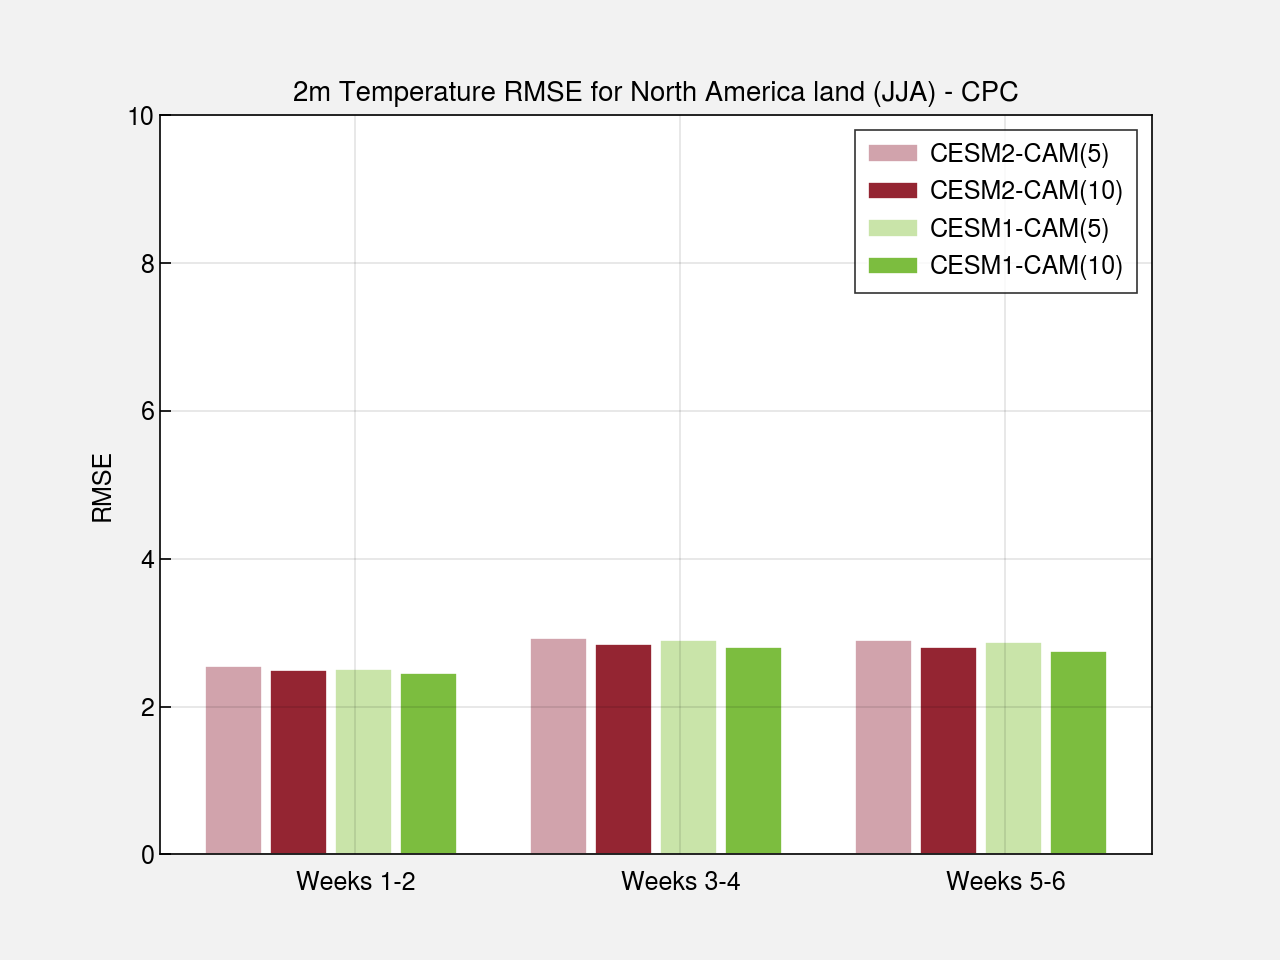

In [66]:
plt.bar(r2_5, bars2_5, width = barWidth, color = "#d1a3ac", edgecolor="white", label="CESM2-CAM(5)")
plt.bar(r2, bars2, width = barWidth, color = "#942532", edgecolor="white", label="CESM2-CAM(10)")
plt.bar(r1_5, bars1_5, width = barWidth, color = "#c9e4a9", edgecolor="white", label="CESM1-CAM(5)")
plt.bar(r1, bars1, width = barWidth, color = "#7cbd3f", edgecolor="white", label="CESM1-CAM(10)")
plt.xticks([r + barWidth + 0.2 for r in range(len(bars1))], ["Weeks 1-2", "Weeks 3-4", "Weeks 5-6"])
plt.tick_params(axis = "y", direction = "in", which = "both")
plt.tick_params(axis = "y", which = "minor", left = False)
plt.tick_params(axis = "x", which = "both", bottom = False, top = False)
if metric=="acc":
    y_locator = FixedLocator([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]) #for rps and acc
    plt.gca().yaxis.set_major_locator(y_locator) #for rps and acc
    plt.ylim(0,1.0) #for rps and acc
elif metric=="rps":
    plt.ylim(0,1.5)
elif metric=="crpss":
    plt.ylim(-0.3,0.1) #for crpss
elif metric=="crps":
    plt.ylim(0,6.0) #for crps
elif metric=="rmse":
    plt.ylim(0,10.0) #for rmse
plt.ylabel(metric.upper())
plt.title("2m Temperature "+metric.upper()+" for "+domain+" land (JJA) - "+verifdata)
plt.legend(borderaxespad=0.6,edgecolor="black")
if domain == "North America":
    plt.savefig(metric+"_NAland_JJA_"+verifdata+".jpg",dpi=300,bbox_inches="tight")
elif domain == "global":
    plt.savefig(metric+"_globalland_JJA_"+verifdata+".jpg",dpi=300,bbox_inches="tight")

Bar plots for with both ensemble spread and rmse

In [67]:
ensprw_djf

<xarray.DataArray (lead: 6)>
dask.array<mean_agg-aggregate, shape=(6,), dtype=float32, chunksize=(3,), chunktype=numpy.ndarray>
Coordinates:
  * lead     (lead) int64 0 1 2 3 4 5

In [68]:
barWidth = 0.075
barsw = [rpsw_djf_aw.TAS.sel(lead=slice(0,1)).mean("lead").compute(),
         rpsw_djf_aw.TAS.sel(lead=slice(2,3)).mean("lead").compute(),
         rpsw_djf_aw.TAS.sel(lead=slice(4,5)).mean("lead").compute()]
rw = np.arange(len(barsw))
barsw_s = [ensprw_djf.sel(lead=slice(0,1)).mean("lead").compute(),
           ensprw_djf.sel(lead=slice(2,3)).mean("lead").compute(),
           ensprw_djf.sel(lead=slice(4,5)).mean("lead").compute()]
rw_s = [x + barWidth + 0.025 for x in rw]
bars2_5 = [rps2_5_djf_aw.TAS.sel(lead=slice(0,1)).mean("lead").compute(),
           rps2_5_djf_aw.TAS.sel(lead=slice(2,3)).mean("lead").compute(),
           rps2_5_djf_aw.TAS.sel(lead=slice(4,5)).mean("lead").compute()]
r2_5 = [x + barWidth + 0.025 for x in rw_s]
bars2_5_s = [enspr2_5_djf.sel(lead=slice(0,1)).mean("lead").compute(),
           enspr2_5_djf.sel(lead=slice(2,3)).mean("lead").compute(),
           enspr2_5_djf.sel(lead=slice(4,5)).mean("lead").compute()]
r2_5_s = [x + barWidth + 0.025 for x in r2_5]
bars2 = [rps2_djf_aw.TAS.sel(lead=slice(0,1)).mean("lead").compute(),
         rps2_djf_aw.TAS.sel(lead=slice(2,3)).mean("lead").compute(),
         rps2_djf_aw.TAS.sel(lead=slice(4,5)).mean("lead").compute()]
r2 = [x + barWidth + 0.025 for x in r2_5_s]
bars2_s = [enspr2_djf.sel(lead=slice(0,1)).mean("lead").compute(),
           enspr2_djf.sel(lead=slice(2,3)).mean("lead").compute(),
           enspr2_djf.sel(lead=slice(4,5)).mean("lead").compute()]
r2_s = [x + barWidth + 0.025 for x in r2]
bars1_5 = [rps1_5_djf_aw.TAS.sel(lead=slice(0,1)).mean("lead").compute(),
           rps1_5_djf_aw.TAS.sel(lead=slice(2,3)).mean("lead").compute(),
           rps1_5_djf_aw.TAS.sel(lead=slice(4,5)).mean("lead").compute()]
r1_5 = [x + barWidth + 0.025 for x in r2_s]
bars1_5_s = [enspr1_5_djf.sel(lead=slice(0,1)).mean("lead").compute(),
             enspr1_5_djf.sel(lead=slice(2,3)).mean("lead").compute(),
             enspr1_5_djf.sel(lead=slice(4,5)).mean("lead").compute()]
r1_5_s = [x + barWidth + 0.025 for x in r1_5]
bars1 = [rps1_djf_aw.TAS.sel(lead=slice(0,1)).mean("lead").compute(),
         rps1_djf_aw.TAS.sel(lead=slice(2,3)).mean("lead").compute(),
         rps1_djf_aw.TAS.sel(lead=slice(4,5)).mean("lead").compute()]
r1 = [x + barWidth + 0.025 for x in r1_5_s]
bars1_s = [enspr1_djf.sel(lead=slice(0,1)).mean("lead").compute(),
           enspr1_djf.sel(lead=slice(2,3)).mean("lead").compute(),
           enspr1_djf.sel(lead=slice(4,5)).mean("lead").compute()]
r1_s = [x + barWidth + 0.025 for x in r1]

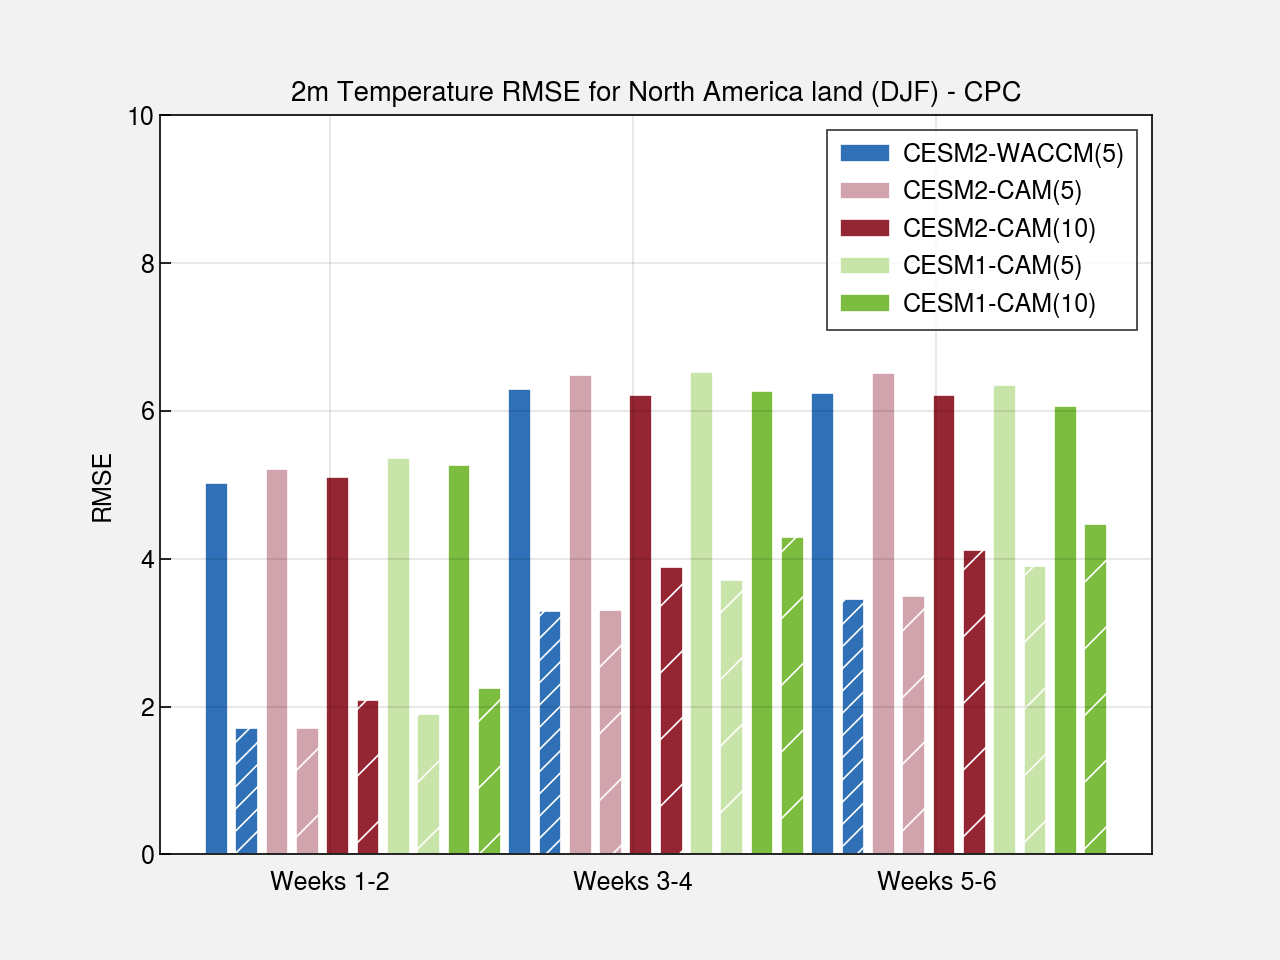

In [70]:
plt.bar(rw, barsw, width = barWidth, color = "#2f70b7", edgecolor="white", label="CESM2-WACCM(5)")
plt.bar(rw_s, barsw_s, width = barWidth, color = "#2f70b7", edgecolor="white", hatch="///")
plt.bar(r2_5, bars2_5, width = barWidth, color = "#d1a3ac", edgecolor="white", label="CESM2-CAM(5)")
plt.bar(r2_5_s, bars2_5_s, width = barWidth, color = "#d1a3ac", edgecolor="white", hatch="/")
plt.bar(r2, bars2, width = barWidth, color = "#942532", edgecolor="white", label="CESM2-CAM(10)")
plt.bar(r2_s, bars2_s, width = barWidth, color = "#942532", edgecolor="white", hatch="/")
plt.bar(r1_5, bars1_5, width = barWidth, color = "#c9e4a9", edgecolor="white", label="CESM1-CAM(5)")
plt.bar(r1_5_s, bars1_5_s, width = barWidth, color = "#c9e4a9", edgecolor="white", hatch="/")
plt.bar(r1, bars1, width = barWidth, color = "#7cbd3f", edgecolor="white", label="CESM1-CAM(10)")
plt.bar(r1_s, bars1_s, width = barWidth, color = "#7cbd3f", edgecolor="white", hatch="/")
plt.xticks([r + barWidth + 0.3 for r in range(len(bars1))], ["Weeks 1-2", "Weeks 3-4", "Weeks 5-6"])
plt.tick_params(axis = "y", direction = "in", which = "both")
plt.tick_params(axis = "y", which = "minor", left = False)
plt.tick_params(axis = "x", which = "both", bottom = False, top = False)
if metric=="acc":
    y_locator = FixedLocator([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]) #for rps and acc
    plt.gca().yaxis.set_major_locator(y_locator) #for rps and acc
    plt.ylim(0,1.0) #for rps and acc
elif metric=="rps":
    plt.ylim(0,1.5)
elif metric=="crpss":
    plt.ylim(-0.3,0.1) #for crpss
elif metric=="crps":
    plt.ylim(0,6.0) #for crps
elif metric=="rmse":
    plt.ylim(0,10.0) #for rmse
plt.ylabel(metric.upper())
plt.title("2m Temperature "+metric.upper()+" for "+domain+" land (DJF) - "+verifdata)
plt.legend(borderaxespad=0.6,edgecolor="black")
if domain == "North America":
    plt.savefig(metric+"_NAland_DJF_"+verifdata+".jpg",dpi=300,bbox_inches="tight")
elif domain == "global":
    plt.savefig(metric+"_globalland_DJF_"+verifdata+".jpg",dpi=300,bbox_inches="tight")